# Define an Entity

In [1]:
import crestdsl.model as crest
from crestdsl.simulation import Simulator

In [2]:
# define the required resources
onOff = crest.Resource(unit="onOff", domain=["on", "off"])
watt = crest.Resource(unit="Watt", domain=crest.REAL)  
celsius = crest.Resource(unit="Celsius", domain=crest.REAL)
time = crest.Resource(unit="Time", domain=crest.REAL)

class HeatModule(crest.Entity):
    switch = crest.Input(resource=onOff, value="on")
    electricity = crest.Input(resource=watt, value=0)
    internal_temp = crest.Local(resource=celsius, value=0)
    timer = crest.Local(resource=time, value=0)
    heating = crest.Output(resource=watt, value=0)
    
    # states
    off = current = crest.State()
    on = crest.State()
    error = crest.State()
    
    # transitions
    @crest.transition(source=off, target=on)
    def to_on(self):
        return self.switch.value == "on" and self.timer.value <= 0 and self.electricity.value >= 200
    @crest.transition(source=on, target=off)
    def to_off(self):
        return self.switch.value != "on" or self.timer.value >= 30 or self.electricity.value < 200
    @crest.transition(source=on, target=error)
    def to_error(self):
        return self.internal_temp.value >= 400
    
    # updates for heat energy output
    @crest.update(state=on, target=heating)
    def on_update_output(self, dt):
        # 50 per cent efficiency
        return self.electricity.value * 0.5 
    @crest.update(state=off, target=heating)
    def off_update_output(self, dt):
        return 0
    @crest.update(state=error, target=heating)
    def error_update_output(self, dt):
        return 0
    
    # update timer:
    @crest.update(state=on, target=timer)
    def on_update_timer(self, dt):
        return self.timer.value + dt
    @crest.update(state=off, target=timer)
    def off_update_timer(self, dt):
        new_value = self.timer.value - 2 * dt
        if new_value <= 0:   # don't go below 0
            return 0
        else:
            return new_value

    # updates for internal_temp
    @crest.update(state=on, target=internal_temp)
    def on_update_internal_temp(self, dt):
        # if more than 200 watt, we grow
        # one tenth degree per extra watt per time unit
        # if lower, we sink at the same rate
        factor = (self.electricity.value - 200) / 10
        
        if self.electricity.value >= 200:
            return self.internal_temp.value + factor * dt
        else:
            new_value = self.internal_temp.value + factor * dt
            return max(new_value, 22)  # don't go below 22
        
    @crest.update(state=[off,error], target=internal_temp)
    def off_error_update_internal_temp(self, dt):
        # see formula above
        new_value = self.internal_temp.value - 20 * dt
        return max(new_value, 22)  # don't go below 22


# Plot as GraphViz

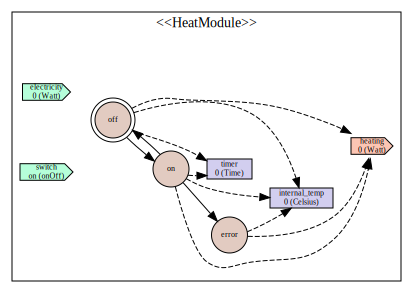

In [3]:
from crestdsl.ui.dotter import plot as graphviz_plot
graphviz_plot(HeatModule())

# Interactive Plotting

In [4]:
from crestdsl.ui import plot
plot(HeatModule())

# Simulate and display trace data

In [5]:
module = HeatModule()
module.switch.value = "on"
module.electricity.value = 275
sim = Simulator(module)
sim.advance(30)
sim.trace.data

,timestamp,HeatModule,HeatModule.electricity,HeatModule.switch,HeatModule.heating,HeatModule.internal_temp,HeatModule.timer
0,0,HeatModule.off,275,on,0.0,0.0,0.0
1,0,HeatModule.off,275,on,0.0,0.0,0.0
2,0,HeatModule.off,275,on,0.0,22.0,0.0
3,0,HeatModule.on,275,on,137.5,22.0,0.0
4,0,HeatModule.on,275,on,137.5,22.0,0.0
5,0,HeatModule.on,275,on,137.5,22.0,0.0
6,30,HeatModule.on,275,on,137.5,247.0,30.0
7,30,HeatModule.off,275,on,0.0,247.0,30.0
8,30,HeatModule.off,275,on,0.0,247.0,30.0


# Plot traces as graph

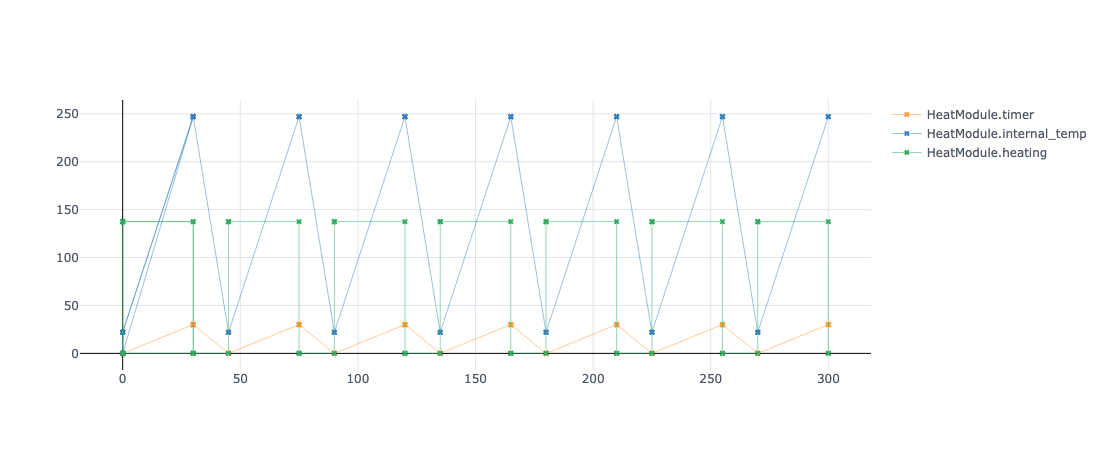

In [6]:
sim.advance(270)  # get a bit more data
sim.trace.plot(traces=[module.timer, module.internal_temp, module.heating])